In [46]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, GRU
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam, Adagrad, RMSprop

from sklearn.utils import class_weight

In [0]:
train_data_path='/content/drive/My Drive/respiratory-dataset/train/data'
train_labels_path='/content/drive/My Drive/respiratory-dataset/train/labels'
test_data_path='/content/drive/My Drive/respiratory-dataset/test/data'
test_labels_path='/content/drive/My Drive/respiratory-dataset/test/labels'

In [0]:
def get_data(path):
  print(path)
  f = open(path, "r")
  X = []
  l = f.readlines()
  n_mfcc = 30
  for idx, elm in enumerate(l):
    elm = elm.split('\n')[0]
    vec_str = elm.split(',')

    m = len(vec_str)
    vec = np.zeros(m)
    for i in range(m):
      vec[i] = float(vec_str[i])
    X.append(np.reshape(vec, (int(m / n_mfcc), n_mfcc)))
    if (idx % 100 == 0):
      print("Data nb {}".format(idx))
  f.close()
  return X

def get_labels(path):
  print(path)
  f = open(path, "r")
  s = f.read()
  s = s.split('\n')[0]
  labels_str = s.split(',')
  y = np.zeros(len(labels_str))
  for idx, lab in enumerate(labels_str):
    y[idx] = float(lab)
    if (idx % 100 == 0):
      print("Label nb {}".format(idx))
  return y

In [50]:
X_train = get_data(train_data_path)
y_train = get_labels(train_labels_path)
X_test = get_data(test_data_path)
y_test = get_labels(test_labels_path)

/content/drive/My Drive/respiratory-dataset/train/data
Data nb 0
Data nb 100
Data nb 200
Data nb 300
Data nb 400
Data nb 500
Data nb 600
Data nb 700
Data nb 800
Data nb 900
Data nb 1000
Data nb 1100
Data nb 1200
Data nb 1300
Data nb 1400
Data nb 1500
Data nb 1600
Data nb 1700
Data nb 1800
Data nb 1900
Data nb 2000
Data nb 2100
/content/drive/My Drive/respiratory-dataset/train/labels
Label nb 0
Label nb 100
Label nb 200
Label nb 300
Label nb 400
Label nb 500
Label nb 600
Label nb 700
Label nb 800
Label nb 900
Label nb 1000
Label nb 1100
Label nb 1200
Label nb 1300
Label nb 1400
Label nb 1500
Label nb 1600
Label nb 1700
Label nb 1800
Label nb 1900
Label nb 2000
Label nb 2100
/content/drive/My Drive/respiratory-dataset/test/data
Data nb 0
/content/drive/My Drive/respiratory-dataset/test/labels
Label nb 0


In [0]:
def plot_histogram(y_train):
  '''
  Plot the histogram of the data
  '''
  labels = ['URTI', 'Healthy', 'COPD', 'Pneumonia']
  _, y = np.unique(y_train, return_counts=True)
  x = np.arange(len(labels))  # the label locations
  width = 0.6  # the width of the bars
  
  fig, ax = plt.subplots(figsize=(12,7))
  ax.bar(x, y, width, color='royalblue', alpha=0.7)
  
  # Add some text for labels, title and custom x-axis tick labels, etc.
  ax.set_ylabel('Nbr data')
  ax.set_title('Class dataset repartition')
  ax.set_xticks(x)
  ax.set_xticklabels(labels)
  fig.tight_layout()
  plt.show()

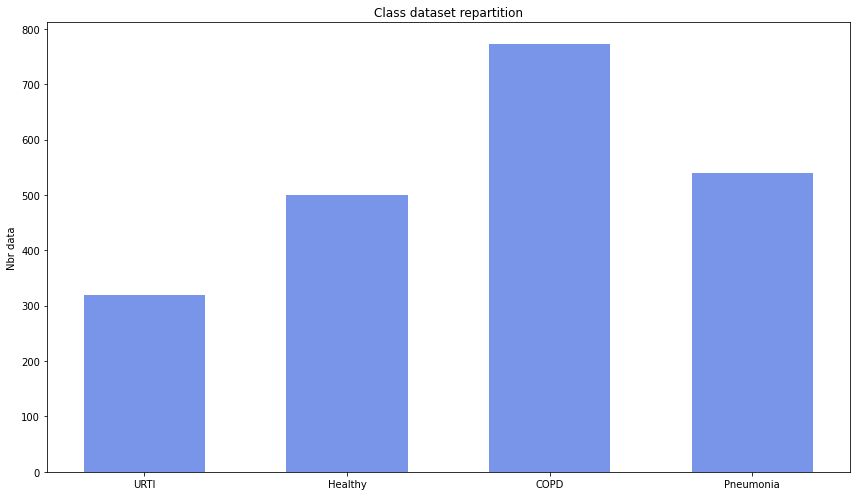

In [52]:
plot_histogram(y_train)

In [0]:
## padding data with 0
## then we wil use masking
## !!! not enough memory to padd
def padd_data(X, max_len, value):
  '''
  padd all the data with value until max_len
  '''
  n_mfcc = X[0].shape[-1]

  for idx, elm in enumerate(X):
    filled = np.full((max_len - elm.shape[0], n_mfcc), fill_value=value)
    X[idx] = np.concatenate((elm, filled))
  return np.array(X)

In [0]:
class DataGenerator(Sequence):
  def __init__(self, X, y, batch_size):
    self.X = X
    self.y = y
    self.batch_size = batch_size

  # nbr of batch in the sequence
  def __len__(self):
    return math.ceil((len(self.y) / self.batch_size))

  # get batch at the position index
  def __getitem__(self, idx):
    x_data = np.empty((self.batch_size, self.X[idx].shape[0], self.X[idx].shape[1]))
    y_data = np.array((self.batch_size, *self.y[idx].shape))
    x_data[0] = self.X[idx]
    y_data[0] = self.y[idx]
    return x_data, y_data

In [55]:
## build model

model = Sequential()

model.add(GRU(20, return_sequences=True, input_shape=(None, 30), name='input_gru'))
model.add(GRU(20, return_sequences=False, name='hidden_gru'))
model.add(Dense(4, activation='softmax', name='output_dense'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_gru (GRU)              (None, None, 20)          3120      
_________________________________________________________________
hidden_gru (GRU)             (None, 20)                2520      
_________________________________________________________________
output_dense (Dense)         (None, 4)                 84        
Total params: 5,724
Trainable params: 5,724
Non-trainable params: 0
_________________________________________________________________


In [0]:
# compile model
rmsprop = RMSprop(learning_rate=0.001)
#adam = Adam(learning_rate=0.005)
model.compile(optimizer=rmsprop, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [0]:
train_generator = DataGenerator(X_train, y_train, 1)
validation_generator = DataGenerator(X_test, y_test, 1)

In [0]:
def create_class_weight(y_train):
  '''
  Create the class weight dictionnary
  '''
  class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
  dic = {}

  for key, value in enumerate(class_weights):
    dic[key] = value

  return dic

In [59]:
class_weights = create_class_weight(y_train)
class_weights

{0: 1.66640625, 1: 1.0665, 2: 0.6898447606727037, 3: 0.9875}

In [68]:
# fit our model
#history = model.fit_generator(generator=train_generator, validation_data=validation_generator, class_weight=class_weights, epochs=5, verbose=1)
history = model.fit_generator(generator=train_generator, validation_data=validation_generator, epochs=5, verbose=1)

Epoch 1/5
2133/2133 [==============================] - 1209s 567ms/step - loss: 0.4755 - accuracy: 0.8167 - val_loss: 1.1460 - val_accuracy: 0.6383
Epoch 2/5
2133/2133 [==============================] - 1199s 562ms/step - loss: 0.4251 - accuracy: 0.8509 - val_loss: 1.3141 - val_accuracy: 0.5745
Epoch 3/5
2133/2133 [==============================] - 1177s 552ms/step - loss: 0.3796 - accuracy: 0.8748 - val_loss: 1.3087 - val_accuracy: 0.6596
Epoch 4/5
2133/2133 [==============================] - 1188s 557ms/step - loss: 0.3319 - accuracy: 0.9020 - val_loss: 1.3457 - val_accuracy: 0.6383
Epoch 5/5
2133/2133 [==============================] - 1185s 556ms/step - loss: 0.3429 - accuracy: 0.8964 - val_loss: 1.6386 - val_accuracy: 0.6809


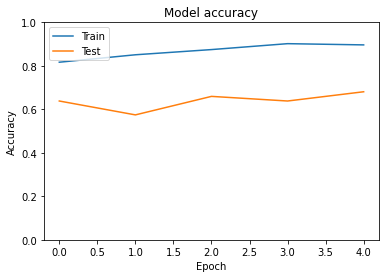

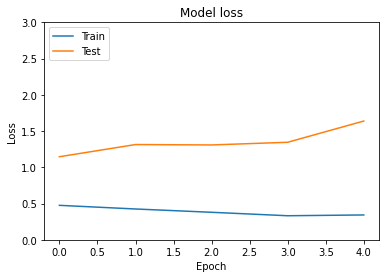

In [71]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(0, 1)
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim(0, 3)
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
## compute accupacy for each class
def compute_accuracy_class(class_generator):
  '''
  Compute accuracy of a class data generator
  return:
  acc_class -> array of accuracy per class
  acc -> total accuracy
  '''
  pred = model.predict_generator(generator=validation_generator)
  acc_class, nb_class = np.zeros(4), np.zeros(4)
  acc, n = 0, 0

  for idx, elm in enumerate(pred):
    label_pred = np.argmax(elm)
    label_true = int(validation_generator.y[idx])
    nb_class[label_true] += 1
    if (label_pred == label_true):
      acc += 1
      acc_class[label_true] += 1
    n += 1
  return acc_class / nb_class, acc / n

In [0]:
acc_class, acc = compute_accuracy_class(validation_generator)

In [74]:
print("Total Accuracy {}".format(acc))
print("Classes Accuracy {}".format(acc_class))

Total Accuracy 0.6808510638297872
Classes Accuracy [0.57142857 0.2        0.85       0.9       ]
